# Inspecting condition differences using HsMM

There are several ways to estimate and inspect condition differences:
1. Estimate separate stage durations across conditions
2. Estimate separate bump magnitudes across conditions
3. Estimate different models for each condition

To illustrate these approaches we will rely on the data exctracted in Tutorial 1, note that the sample data will be made accessible soon (i.e. once we found a way to suitably share it).

In [1]:
#Development only
import sys
sys.path.insert(0, "/home/gweindel/owncloud/projects/RUGUU/hsmm-mvpy/src")
%load_ext autoreload
%autoreload 2

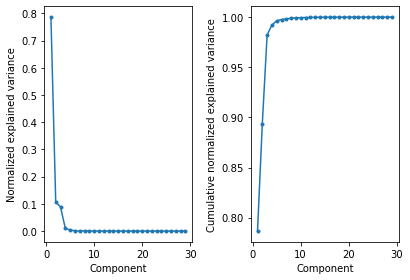

How many PCs (90 and 99% explained variance at component n3 and n4)? 4


In [5]:
import numpy as np
import xarray as xr
import hsmm_mvpy as hsmm

cpus=5#set the number of cores to use for all the code

eeg_data = xr.load_dataset('sample_data/sample_data.nc')

#We create also the position array for the electrodes as we are going to need them to plot the bump topologies
from mne import channels
montage = dict(channels.make_standard_montage('easycap-M1').get_positions())['ch_pos']#In this case electrodes are positioned according to the 10-20 system
positions = np.array([montage[x][:2] for x in eeg_data['electrodes'].values])#Extract x and y positions of each electrode

#And we transform as in the previous tutorial
unstacked_data = hsmm.utils.transform_data(eeg_data)
hsmm_data = hsmm.utils.stack_data(unstacked_data)

## Applying HsMM for all conditions

For the two first applications we rely on a fit of HsMM on all the data.

In [7]:
init = hsmm.models.hsmm(hsmm_data, sf=eeg_data.sfreq, cpus=cpus)

As we don't know yet the number of bumps, we will use the ```backward_estimation()``` method. This method first estimate the max_bump solution (defined based on the bump width and the minimum reaction time) then estimate max_bump - 1 solution by iteratively removing one of the bump and pick the one with the highest likelihood (see Borst & Anderson, [2021](http://jelmerborst.nl/pubs/ACTR_HsMM_MVPA_BorstAnderson_preprint.pdf)) and repeat this until the 1 bump solution. In order to be sure to explore the likelihood landscape we should also define random starting points for the initial guesses on parameters and magnitudes of the bumps but for the sake of the tutorial let's be fast.

In [9]:
bests = init.backward_estimation()

Estimating all solutions for maximal number of bumps (6) with 0 random starting points
Estimating parameters for 6 bumps model with 0 random starting points
Likelihood of uninitialized parameters has been preferred over initialized model. Consider adding starting points?
Parameters estimated for 6 bumps model
Estimating all solutions for 5 number of bumps
Estimating all solutions for 4 number of bumps
Estimating all solutions for 3 number of bumps
Estimating all solutions for 2 number of bumps
Estimating all solutions for 1 number of bumps


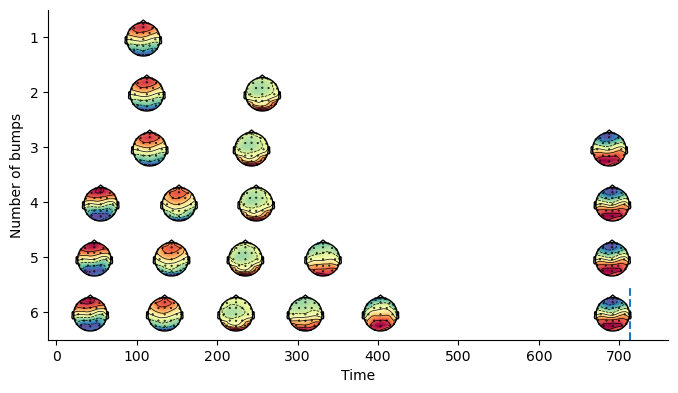

In [13]:
#topo_bests = init.multiple_topologies(eeg_data, bests.eventprobs)
#times = [init.bump_times(x) for x in bests.eventprobs]

hsmm.visu.plot_topo_timecourse(topo_bests[::-1], times,
                          positions, bump_size=init.bump_width_samples, time_step = 1000/eeg_data.sfreq, magnify=2, 
                          times_to_display = np.mean(init.ends - init.starts), 
                          figsize=(8,4), ylabels={'Number of bumps':np.arange(init.max_bumps,0,-1)})

Next we test the required number of bumps with the LOOCV approache (see tutorial 3)

In [14]:
loocv = hsmm.utils.loocv_mp(init, unstacked_data, bests, cpus=cpus)
hsmm.visu.plot_LOOCV(loocv, pvals=True, test='t-test', indiv=True)#Colored shaded lines represent individuals

LOOCV for model with 1 bump(s)
LOOCV for model with 2 bump(s)
LOOCV for model with 3 bump(s)
LOOCV for model with 4 bump(s)
LOOCV for model with 5 bump(s)
LOOCV for model with 6 bump(s)


With only four participants it is not very convincing but the 3 bump solution emerges so let's go with it

## 1. Estimate separate stage durations across conditions

In a design with a speed-accuracy trade-off such as this one, predictions on stages are rather straightforward. We expect that the main difference in latencies should be found in the decision stage although we can expect effects on other stages [Steinmann2018, Weindel2021]. To leave enough flexibility to the model we do not constrain the latencies to be fixed across conditions, but if we want to avoid extra degrees of freedom and test a hypothesis on a specific stage we can also fix stage duration as we do for magnitudes (see next application).

In [21]:
subset

<xarray.DataArray (samples: 210, participant: 0, epochs: 0, component: 4)>
array([], shape=(210, 0, 0, 4), dtype=float64)
Coordinates:
  * participant  (participant) object 
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 203 204 205 206 207 208 209
  * epochs       (epochs) int64 
  * component    (component) int64 0 1 2 3

In [23]:
subset = unstacked_data.where(eeg_data.event.str.contains('SP'),drop=True)
hsmm_speed_data = hsmm.utils.stack_data(subset)
init_speed = hsmm.models.hsmm(hsmm_speed_data,
                       sf=eeg_data.sfreq, cpus=cpus, estimate_magnitudes=False)#Here we turn off the estimation of magnitudes so only stage durations are free to vary

subset = unstacked_data.where(eeg_data.event.str.contains('AC'),drop=True)
hsmm_accuracy_data = hsmm.utils.stack_data(subset)
init_accuracy = hsmm.models.hsmm(hsmm_accuracy_data,
                       sf=eeg_data.sfreq, cpus=cpus, estimate_magnitudes=False)

In [25]:
speed = init_speed.fit_single(3, magnitudes=bests.sel(n_bumps=3).magnitudes)#Having fixed magnitudes we need to pass those estimated from the previous iterative method
accuracy = init_accuracy.fit_single(3, magnitudes=bests.sel(n_bumps=3).magnitudes)

Estimating parameters for 3 bumps model with 0 random starting points
Parameters estimated for 3 bumps model
Estimating parameters for 3 bumps model with 0 random starting points
Parameters estimated for 3 bumps model


In [26]:
condition_times = []
for cond in zip([init_speed, init_accuracy],
                [speed, accuracy]):
    condition_times.append(cond[0].bump_times(cond[1].eventprobs, mean=False))
condition_times = np.array(condition_times,dtype=object)


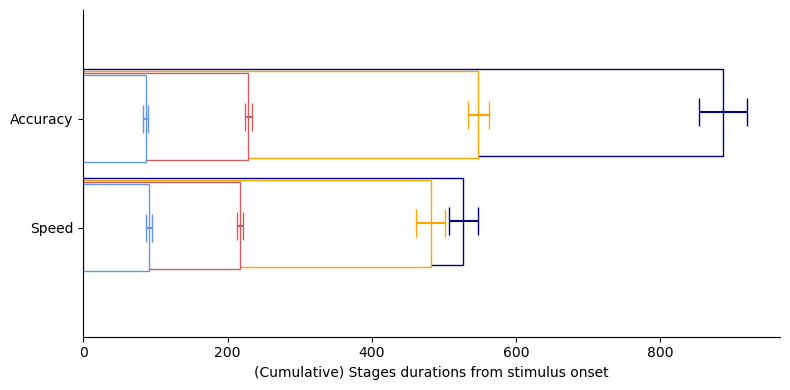

In [27]:
hsmm.visu.plot_latencies_average(condition_times, init.bump_width_samples, 1000/init.sf, 
                labels= ['Speed', 'Accuracy'], errs='ci');

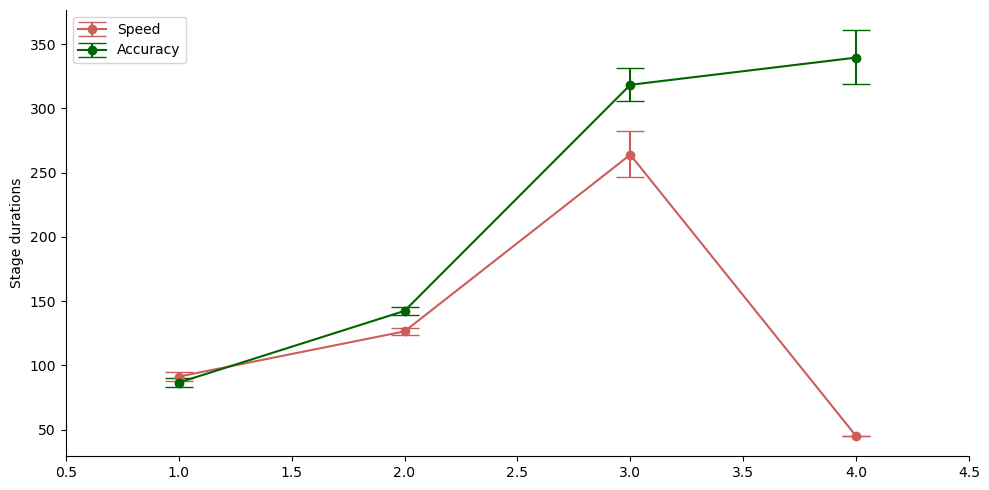

In [28]:
hsmm.visu.plot_latencies(condition_times,
    init.bump_width_samples, kind='point',legend=True,
    labels= ['Speed', 'Accuracy'], errs='ci', time_step=1000/init.sf,
    colors=["indianred","darkgreen"], figsize=(10,5));

We see indeed that the speed-accuracy is driven mainly by one stage which could then be the decision stage. The other stages remain relatively constant we could further analyze these differences with a statistical model.

## 2. Estimate different topologies across conditions (left and right responses)

Given the conditions used in the dataset, it's is hard to think of difference in topologies arising from a condition where participant have to speed up *vs* a condition where they have to be accurate. A more interesting analysis regarding topologies would be response side. We should be able to see Lateralized Readiness Potential congruent with the response side, and as we expect this effect to be located on the bump representing response execution we could choose to only estimate this on the last bump.

In [29]:
eeg_data

<xarray.Dataset>
Dimensions:      (epochs: 200, samples: 210, participant: 4, electrodes: 30)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 203 204 205 206 207 208 209
  * electrodes   (electrodes) object 'Fp1' 'Fp2' 'AFz' ... 'CPz' 'CP2' 'CP6'
  * participant  (participant) object '0025' '0024' '0023' '0022'
Data variables:
    data         (participant, epochs, electrodes, samples) float64 2.891e+06...
    event        (participant, epochs) object 'SP/stim_right/resp_left' ... '...
Attributes:
    sfreq:    100

In [30]:
subset = unstacked_data.where(eeg_data.event.str.contains('resp_left'),drop=True)
hsmm_l_data = hsmm.utils.stack_data(subset,'participant')
init_l = hsmm.models.hsmm(hsmm_l_data,
                       sf=eeg_data.sfreq, cpus=cpus, estimate_parameters=False, magnitudes_to_fix=[0,1])

subset = unstacked_data.where(eeg_data.event.str.contains('resp_right'),drop=True)
hsmm_r_data = hsmm.utils.stack_data(subset,'participant')
init_r = hsmm.models.hsmm(hsmm_r_data,
                       sf=eeg_data.sfreq, cpus=cpus, estimate_parameters=False, magnitudes_to_fix=[0,1])

In [31]:
left_stim = init_l.fit_single(3, parameters=bests.sel(n_bumps=3).parameters,magnitudes=bests.sel(n_bumps=3).magnitudes)
right_stim = init_r.fit_single(3, parameters=bests.sel(n_bumps=3).parameters,magnitudes=bests.sel(n_bumps=3).magnitudes)

Estimating parameters for 3 bumps model with 0 random starting points
Parameters estimated for 3 bumps model
Estimating parameters for 3 bumps model with 0 random starting points
Parameters estimated for 3 bumps model


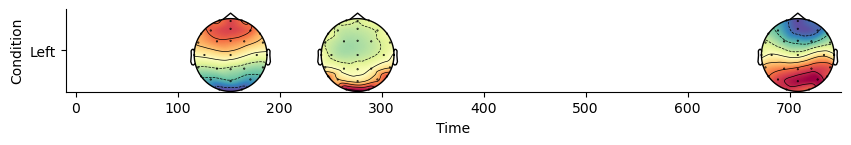

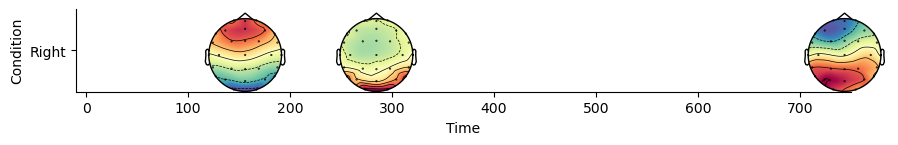

In [33]:
for condition in zip([left_stim, right_stim],
                     [init_l, init_r],
                     [hsmm_l_data, hsmm_r_data],
                    ['Left', 'Right']):
    electrodes = condition[1].compute_topo(eeg_data, condition[0].eventprobs)
    hsmm.visu.plot_topo_timecourse(electrodes, condition[1].bump_times(condition[0].eventprobs),
                          positions, bump_size=condition[1].bump_width_samples, time_step = 10,  
                          times_to_display = np.mean(condition[1].ends - condition[1].starts),max_time=750,
                          figsize=(10,1), ylabels={'Condition':[condition[3]]}, magnify=5)

Success, the only bump that changed in magnitude is the last one as imposed with a (slight) shift in frontal negativity from left to right (likely LRPs but again, only four participants)

[Coming section : LOOCV for conditions]

# 3. Estimate different models for each condition


Lastly we can fit two completely separate models to the two speed-accuracy conditions. This is the most flexible approach and requires enough data in each condition, it should however systematically been tested when there is a suspicion on a difference on number of stages as the two previous applications assumed the same number of stage

### Applying HsMM separately for the speed condition

Initializing data for the speed condition

In [34]:
subset = unstacked_data.where(eeg_data.event.str.contains('SP'),drop=True)
hsmm_speed_data = hsmm.utils.stack_data(subset,'participant')
init_speed = hsmm.models.hsmm(hsmm_speed_data,
                       sf=eeg_data.sfreq, cpus=cpus)

Estimating all solutions for maximal number of bumps (6) with 0 random starting points
Estimating parameters for 6 bumps model with 0 random starting points
Parameters estimated for 6 bumps model
Estimating all solutions for 5 number of bumps
Estimating all solutions for 4 number of bumps
Estimating all solutions for 3 number of bumps
Estimating all solutions for 2 number of bumps
Estimating all solutions for 1 number of bumps


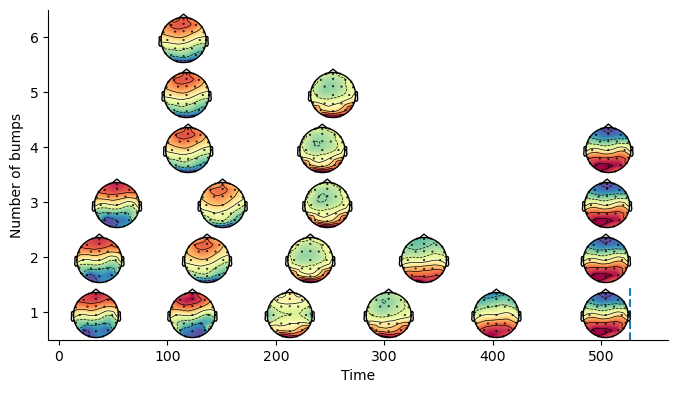

In [35]:
bests_speed = init_speed.backward_estimation(max_starting_points=1)

topo_bests_speed = init_speed.multiple_topologies(eeg_data, bests_speed.eventprobs)

hsmm.visu.plot_topo_timecourse(topo_bests_speed[::-1], [init_speed.bump_times(x) for x in bests_speed.eventprobs],
                          positions, bump_size=init_speed.bump_width_samples, time_step = 10, magnify=2, 
                          times_to_display = np.mean(init_speed.ends - init_speed.starts), 
                          figsize=(8,4), ylabels={'Number of bumps':np.arange(init_speed.max_bumps)+1})

Compute LOOCV on speed data only

LOOCV for model with 1 bump(s)
LOOCV for model with 2 bump(s)
LOOCV for model with 3 bump(s)
LOOCV for model with 4 bump(s)
LOOCV for model with 5 bump(s)
LOOCV for model with 6 bump(s)


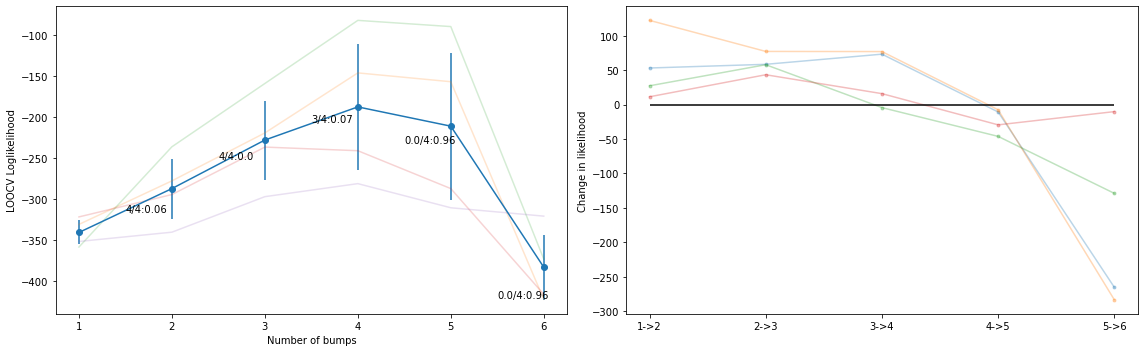

In [36]:
loocv = hsmm.utils.loocv_mp(init_speed, subset, bests_speed, cpus=cpus)
hsmm.visu.plot_LOOCV(loocv, pvals=True, test='t-test', indiv=True)#Colored shaded lines represent individuals

As in the general model, the best number of bumps given the absolute number and the t-test in the improvement is 3 bumps

### Applying HsMM separately for the accuracy condition

Initializing data for the accuracy condition

In [37]:
subset = unstacked_data.where(eeg_data.event.str.contains('AC'),drop=True)
hsmm_accuracy_data = hsmm.utils.stack_data(subset,'participant')
init_accuracy = hsmm.models.hsmm(hsmm_accuracy_data,
                       sf=eeg_data.sfreq, cpus=cpus)

Estimating the different number of bump solution using the backward estimation (first estimate max_bump solution then estimate max_bump - 1 solution by iteratively removing one of the bump and pick the one with the highest likelihood).

Note that because the minimum RT is higher in the accuracy condition, the maximum possible number of bumps is 7

Estimating all solutions for maximal number of bumps (8) with 0 random starting points
Estimating parameters for 8 bumps model with 0 random starting points
Parameters estimated for 8 bumps model
Estimating all solutions for 7 number of bumps
Estimating all solutions for 6 number of bumps
Estimating all solutions for 5 number of bumps
Estimating all solutions for 4 number of bumps
Estimating all solutions for 3 number of bumps
Estimating all solutions for 2 number of bumps
Estimating all solutions for 1 number of bumps


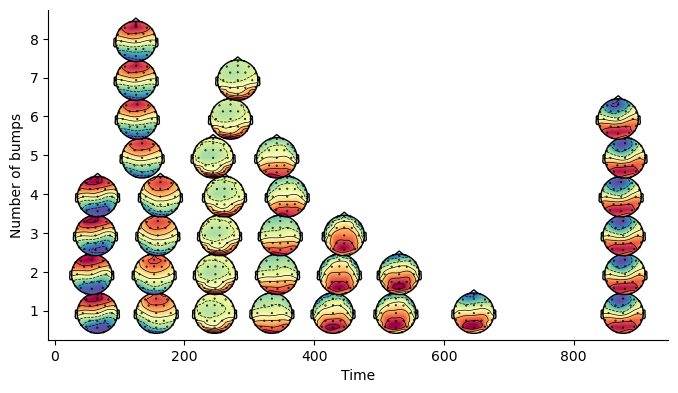

In [38]:
bests_accuracy = init_accuracy.backward_estimation(max_starting_points=1)

topo_bests_accuracy = init_accuracy.multiple_topologies(eeg_data, bests_accuracy.eventprobs)

hsmm.visu.plot_topo_timecourse(topo_bests_accuracy[::-1], [init_accuracy.bump_times(x) for x in bests_accuracy.eventprobs],
                          positions, bump_size=init_accuracy.bump_width_samples, time_step = 10, magnify=3, 
                          times_to_display = np.mean(init_accuracy.ends - init_accuracy.starts), 
                          figsize=(8,4), ylabels={'Number of bumps':np.arange(init_accuracy.max_bumps)+1})

LOOCV for model with 1 bump(s)
LOOCV for model with 2 bump(s)
LOOCV for model with 3 bump(s)
LOOCV for model with 4 bump(s)
LOOCV for model with 5 bump(s)
LOOCV for model with 6 bump(s)
LOOCV for model with 7 bump(s)
LOOCV for model with 8 bump(s)


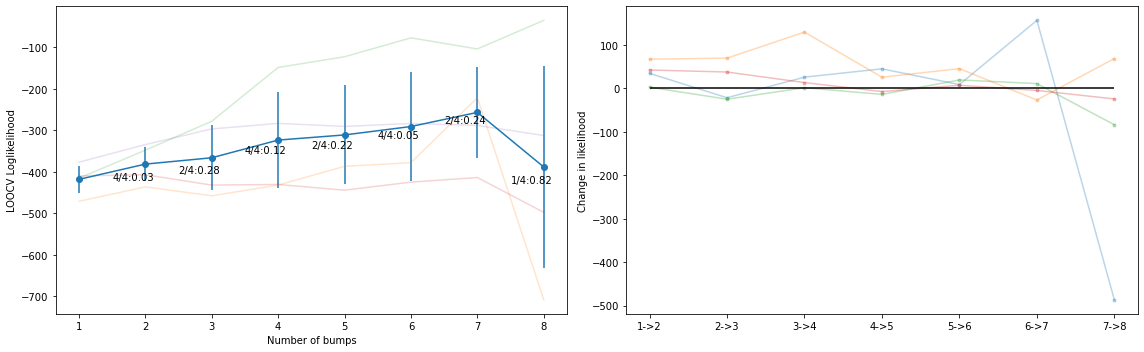

In [39]:
loocv = hsmm.utils.loocv_mp(init_accuracy, subset, bests_accuracy, cpus=cpus)
hsmm.visu.plot_LOOCV(loocv, pvals=True, test='t-test', indiv=True)#Colored shaded lines represent individuals

In the case of the accuracy condition the LOOCV is a bit harder to interpret with only 4 participants, but we note that only 2/4 improve from 2 to 3 bumps and 4/4 improve when going from 3 to 4 participants (note in this case the 6 bumps solution could have been prefered). If we settle to this 4 bump solution it is congruent with the result found by [Van Maanen, Portoles, & Borst (2021)](https://link.springer.com/article/10.1007/s42113-021-00105-2) where they estimate one bump more in the accuracy condition compared to the speed condition.

Despite having different models we can still compare the magnitudes as well as the latencies:

In [40]:
estimates_speed = bests_speed.sel(n_bumps=3).drop_vars('n_bumps')
estimates_accuracy = bests_accuracy.sel(n_bumps=4).drop_vars('n_bumps')

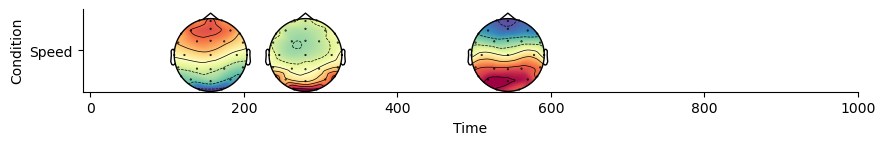

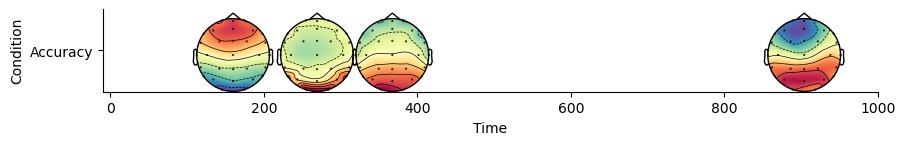

In [45]:
for condition in zip([estimates_speed, estimates_accuracy],
                     [init_speed, init_accuracy],
                     [hsmm_speed_data, hsmm_accuracy_data],
                    ['Speed', 'Accuracy']):
    electrodes = condition[1].compute_topo(eeg_data, condition[0].eventprobs)
    hsmm.visu.plot_topo_timecourse(electrodes, condition[1].bump_times(condition[0].eventprobs),
                          positions, bump_size=condition[1].bump_width_samples, time_step = 10,  
                          times_to_display = np.mean(condition[1].ends - condition[1].starts),max_time=1000,
                          figsize=(10,1), ylabels={'Condition':[condition[3]]}, magnify=5)

In [46]:
condition_times = []
for cond in zip([init_speed, init_accuracy],
                [estimates_speed, estimates_accuracy]):
    condition_times.append(cond[0].bump_times(cond[1].eventprobs, mean=False))
condition_times = np.array(condition_times, dtype=object)

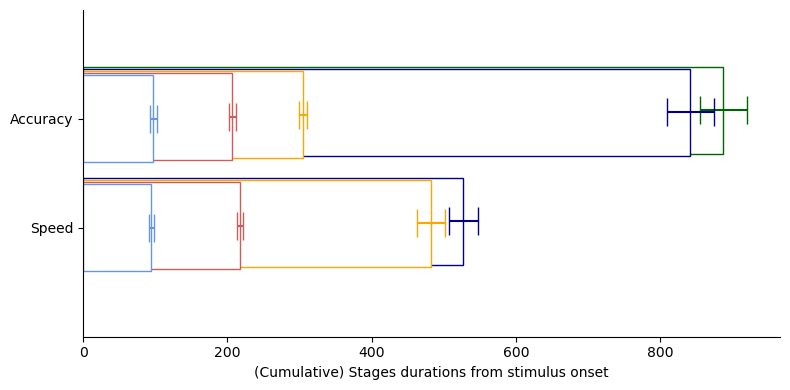

In [47]:
hsmm.visu.plot_latencies_average(condition_times, init.bump_width_samples, 1000/init.sf, 
                labels= ['Speed', 'Accuracy'], errs='ci');

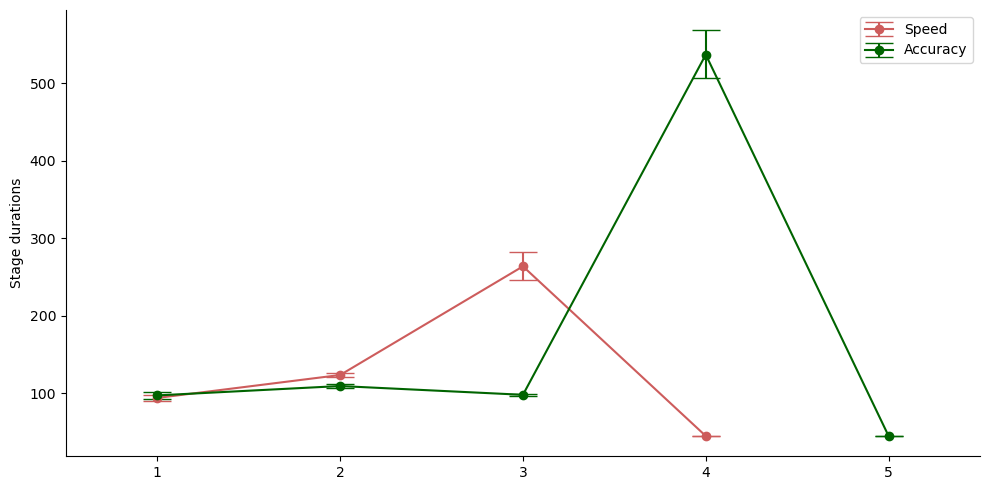

In [48]:
hsmm.visu.plot_latencies(condition_times,
    init.bump_width_samples, kind='point',legend=True,
    labels= ['Speed', 'Accuracy'], errs='ci', time_step=1000/init.sf,
    colors=["indianred","darkgreen"], figsize=(10,5));